<a href="https://colab.research.google.com/github/hateley/RAG-chatbot/blob/main/rag_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Question and Answer System using RAG and LangChain
**Author**: Shannon Hateley, PhD  
**Date**: July 31, 2024

<ins>Coding Task</ins>  
Question-Answering for Medical Information on Epkinly & Polivy

<ins>Objective</ins>  
Develop a question & answering system using a large language model that can answer questions related to Epkinly & Polivy in a compliant manner. The goal is to demonstrate your ability to develop a technical solution, apply existing frameworks, and think creatively.  
Provide a walkthrough of the system development.   

Method must use:  
* an LLM framework
* compliance guardrails


<ins>Method Overview</ins>  
The Question and Answer system utilizes the LangChain framework and Retrieval-Augmented Generation (RAG) to access specific information on Epkinly and Polivy. Guardrails will be implemented in the next step.  

<ins>Major Steps</ins>  
1. Scrape linked websites for drug and trial information
2. Ingest data and store as embeddings
3. Initiate Q&A chatbot with RAG
4. Add guardrails


#### Required libraries:
* **langchain**: The GenAI framework used to process and combine the chatbot components
* **openai**: OpenAI Python client, to interact with the OpenAI API and generate answers
* **pinecone-client**: Python client for the Pinecone API where the knowledge base embeddings are stored in a vector database
* **other**: Various data wrangling, visualizing, and text processing libraries

In [2]:
# install libraries

!pip install -qU \
    langchain==0.0.354 \
    openai==1.6.1 \
    pinecone-client==3.1.0 \
    tiktoken==0.5.2 \
    pandas==2.1.4 \
    matplotlib \
    seaborn \
    tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.3/803.3 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.0/211.0 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.


### 1. Scrape websites
Performed independently (see scrape_webpages.ipynb), then loaded into colab notebook for experdiancy here.

### 2. Ingest data and store as embeddings
The websites need to be converted to embeddings to be referenced by our system. And storing them in an indexed vector database makes retrieval faster in cases of a lot of data.


In [9]:
# setup environment for generating embeddings

import pandas as pd
from langchain.document_loaders import DataFrameLoader
import tiktoken
import matplotlib.pyplot as plt
import seaborn as sns
from langchain.text_splitter import RecursiveCharacterTextSplitter
from tqdm.auto import tqdm
from pinecone import Pinecone
from google.colab import userdata
from pinecone import ServerlessSpec
from langchain.embeddings.openai import OpenAIEmbeddings


In [4]:
# read the scraped webpages as a dataframe
df = pd.read_csv("/content/scraped.tsv", sep='\t')
print(df.columns)

# convert to langchain format for processing
loader = DataFrameLoader(
    df,
    page_content_column="text"
)
docs = loader.load()
print(f"number of sites loaded:{len(docs)}")

Index(['fname', 'text'], dtype='object')
8


In [22]:
# configure tokenizer for desired encoding

tokenizer = tiktoken.get_encoding('cl100k_base')

# set token length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)


tiktoken.encoding_for_model('gpt-3.5-turbo')
token_counts = [tiktoken_len(doc.page_content) for doc in docs]

# function to break up our documents into smaller chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n', '\n', ' ', '']
)

# print original token lengths
print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")

Min: 10
Avg: 5841
Max: 7863


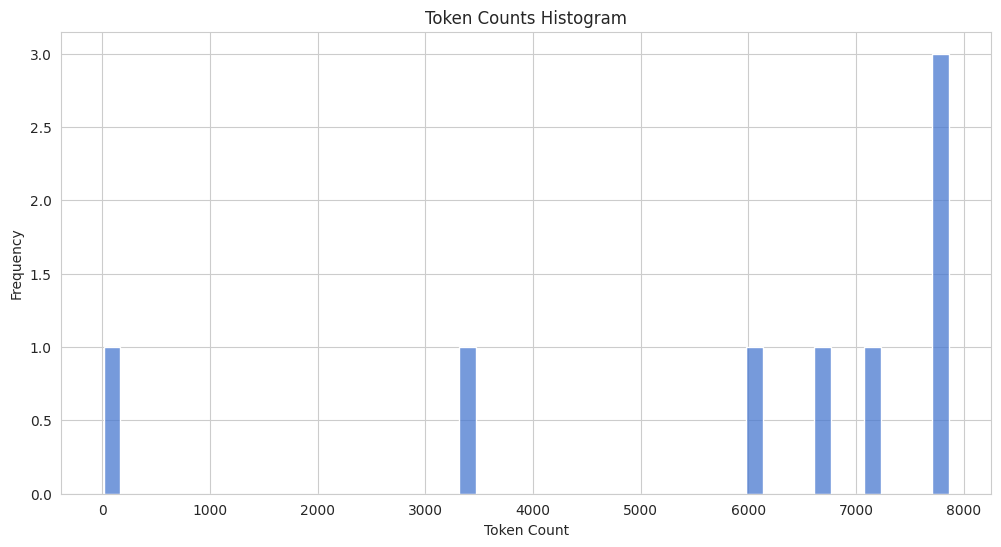

In [17]:
# visualize original lengths

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

In [25]:
#chunk the documents

dataset = []

for doc in tqdm(docs):
    source = doc.metadata['fname'].replace('.txt', '')
    chunks = text_splitter.split_text(doc.page_content)
    for i, chunk in enumerate(chunks):
        dataset.append({
            'text': chunk,
            'source': source
        })

print(f"documents printed into {len(dataset)} total chunks")


  0%|          | 0/8 [00:00<?, ?it/s]

131

#### Create the embeddings and store them in Pinecone

In [10]:
# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = userdata.get('pinecone')

# configure client
pc = Pinecone(api_key=api_key)

spec = ServerlessSpec(
    cloud="aws", region="us-east-1"
)

NameError: name 'pinecone' is not defined

In [41]:
# initialize embeddings in Pinecone

import time

index_name = 'trials-rag'
existing_indexes = [
    index_info["name"] for index_info in pc.list_indexes()
]

# check if index already exists (it shouldn't if this is first time)
if index_name not in existing_indexes:
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=1536,  # dimensionality of ada 002
        metric='cosine',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
time.sleep(1)
# view index stats
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 149}},
 'total_vector_count': 149}

In [ ]:

embed_model = OpenAIEmbeddings(model="text-embedding-ada-002", openai_api_key=userdata.get('genmab_openai'))

In [43]:
# define embedding model parameters
embed_model = OpenAIEmbeddings(model="text-embedding-ada-002", openai_api_key=userdata.get('genmab_openai'))

#embed and store document chunks
from tqdm.auto import tqdm  # for progress bar

data = pd.DataFrame(dataset)
data['chunk-id'] = data.index

batch_size = 100

for i in tqdm(range(0, len(data), batch_size)):
    i_end = min(len(data), i+batch_size)
    # get batch of data
    batch = data.iloc[i:i_end]
    # generate unique ids for each chunk
    ids = [f"{x['chunk-id']}" for i, x in batch.iterrows()]
    # get text to embed
    texts = [x['text'] for _, x in batch.iterrows()]
    # embed text
    embeds = embed_model.embed_documents(texts)
    # get metadata to store in Pinecone
    metadata = [
        {'text': x['text'],
         'source': x['source']} for i, x in batch.iterrows()
    ]
    # add to Pinecone
    index.upsert(vectors=zip(ids, embeds, metadata))

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.1.0 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


  0%|          | 0/2 [00:00<?, ?it/s]

In [44]:
# index values should be updated to include the new embedding vectors
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 149}},
 'total_vector_count': 149}

### 3) Create the chatbot with RAG

To start, we can see that a simple Q&A chatbot probably won't have much knowledge about the drugs or clinical trials.

In [1]:
# set up environment for building the chatbot

import os
from langchain.chat_models import ChatOpenAI
from langchain.schema import (
    SystemMessage,
    HumanMessage,
    AIMessage
)
from langchain.vectorstores import Pinecone

ModuleNotFoundError: No module named 'langchain'

In [4]:
# initialize the ChatOpenAI object
chat = ChatOpenAI(
    openai_api_key=userdata.get('genmab_openai'),
    model='gpt-3.5-turbo'
)

# define the first conversation
messages = [
    SystemMessage(content="You are a helpful assistant."),
    HumanMessage(content="Hi AI, how are you today?"),
    AIMessage(content="I'm great thank you. How can I help you?"),
    HumanMessage(content="I'd like to understand Epkinly.")
]

#feed messages to the chat system
res = chat(messages)

# display chat response
print(res.content)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [8]:
# right now it doesn't know about the info we want to talk about

# add latest AI response to messages
messages.append(res)

# now create a new user prompt
prompt = HumanMessage(
    content="What were the results of the EPCORE NHL-1 trial?"
)
# add to messages
messages.append(prompt)

# send to OpenAI
res = chat(messages)

messages.append(res)

In [9]:
print(res.content)

The EPCORE NHL-1 trial was a Phase 2 clinical trial that evaluated the safety and efficacy of the drug epoetin alfa in treating anemia in patients with non-Hodgkin lymphoma (NHL) who were receiving chemotherapy. The results of the trial showed that epoetin alfa effectively increased hemoglobin levels and reduced the need for blood transfusions in these patients. However, it is important to note that individual results may vary, and it is best to consult with a healthcare professional for specific information about treatment options for NHL.


In [16]:
# right now it doesn't know about the info we want to talk about

# add latest AI response to messages
messages.append(res)

# now create a new user prompt
prompt = HumanMessage(
    content="should I use epoetin alfa?"
)
# add to messages
messages.append(prompt)

# send to OpenAI
res = chat(messages)

messages.append(res)

In [17]:
print(res.content)

Whether or not you should use epoetin alfa depends on your individual medical condition and circumstances. Epoetin alfa is typically prescribed to treat anemia in patients with conditions such as chronic kidney disease, cancer, or HIV who are receiving chemotherapy or other treatments that may cause anemia. It is important to discuss your specific situation with your healthcare provider, who can provide personalized advice and recommendations based on your medical history and needs.


In [46]:
# now that the embeddings are created and store, we can access them anytime like so

text_field = "text"  # the field that contains our text

# initialize the vector store object
vectorstore = Pinecone(
    index, embed_model.embed_query, text_field
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.vectorstores.pinecone.Pinecone` was deprecated in langchain-community 0.0.18 and will be removed in 0.2.0. An updated version of the class exists in the langchain-pinecone package and should be used instead. To use it run `pip install -U langchain-pinecone` and import as `from langchain_pinecone import Pinecone`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_community/vectorstores/pinecone.py:68: UserWarning: Passing in `embedding` as a Callable is deprecated. Please pass in an Embeddings object instead.
  warnings.warn(


In [33]:
query = "What were the results of the EPCORE NHL-1 trial?"

vectorstore.similarity_search(query, k=3)

[Document(page_content='Efficacy was evaluated in 148 patients with DLBCL, NOS, including DLBCL arising from indolent lymphoma, and HGBCL.  EPCORE NHL-1 trial   Primary endpoint*: ORR (CR+PR) \xa0 Select secondary endpoints included2*: CR rate, DOR, DOCR, time to response \xa0 KEY INCLUSION CRITERIA3: ECOG PS 0-2 | Prior CAR T allowed | ≥2 prior lines of antineoplastic therapy, including ≥1 anti-CD20 mAb KEY EXCLUSION CRITERIA: CNS involvement of lymphoma | Allogeneic HSCT or solid organ transplant | Ongoing active infection | Known impaired T-cell immunity \xa0 \xa0 \xa0 \xa0 \xa0 \xa0   DOSING SCHEDULE     SUBCUTANEOUS EPKINLY 48 mg Weekly, cycles 1†-3 Every other week, cycles 4-9 Every 4 weeks, cycles 10+ \xa0 Cycle=28 days.    Patients continued to receive EPKINLY until disease progression or unacceptable toxicity.  Strategies to minimize occurrence and severity of CRS: Step-up dosage: step-up dose 1 of 0.16 mg on C1D1, step-up dose 2 of 0.8 mg on C1D8, and full dose of 48 mg on C1

In [34]:
def augment_prompt(query: str):
    # get top 3 results from knowledge base
    results = vectorstore.similarity_search(query, k=3)
    # get the text from the results
    source_knowledge = "\n".join([x.page_content for x in results])
    # feed into an augmented prompt
    augmented_prompt = f"""Using the contexts below, answer the query.

    Contexts:
    {source_knowledge}

    Query: {query}"""
    return augmented_prompt

In [35]:
print(augment_prompt(query))

Using the contexts below, answer the query.

    Contexts:
    Efficacy was evaluated in 148 patients with DLBCL, NOS, including DLBCL arising from indolent lymphoma, and HGBCL.  EPCORE NHL-1 trial   Primary endpoint*: ORR (CR+PR)   Select secondary endpoints included2*: CR rate, DOR, DOCR, time to response   KEY INCLUSION CRITERIA3: ECOG PS 0-2 | Prior CAR T allowed | ≥2 prior lines of antineoplastic therapy, including ≥1 anti-CD20 mAb KEY EXCLUSION CRITERIA: CNS involvement of lymphoma | Allogeneic HSCT or solid organ transplant | Ongoing active infection | Known impaired T-cell immunity               DOSING SCHEDULE     SUBCUTANEOUS EPKINLY 48 mg Weekly, cycles 1†-3 Every other week, cycles 4-9 Every 4 weeks, cycles 10+   Cycle=28 days.    Patients continued to receive EPKINLY until disease progression or unacceptable toxicity.  Strategies to minimize occurrence and severity of CRS: Step-up dosage: step-up dose 1 of 0.16 mg on C1D1, step-up dose 2 of 0.8 mg on C1D8, and full dose of

In [36]:
# create a new user prompt
prompt = HumanMessage(
    content=augment_prompt(query)
)
# add to messages
messages.append(prompt)

res = chat(messages)

print(res.content)

The EPCORE NHL-1 trial evaluated the efficacy of EPKINLY in treating anemia in patients with diffuse large B-cell lymphoma (DLBCL), including DLBCL arising from indolent lymphoma, and high-grade B-cell lymphoma (HGBCL). The primary endpoint of the trial was the objective response rate (ORR), which includes complete response (CR) and partial response (PR). Secondary endpoints included CR rate, duration of response (DOR), duration of CR (DOCR), and time to response. The dosing schedule for EPKINLY involved administering 48 mg subcutaneously weekly for cycles 1-3, every other week for cycles 4-9, and every 4 weeks for cycles 10 and beyond. Patients continued to receive EPKINLY until disease progression or unacceptable toxicity. Adverse reactions included cytokine release syndrome (CRS), with most reactions occurring early in treatment (cycles 1-3) and decreasing after 12 weeks. The trial showed low discontinuation rates due to adverse reactions, and dosage interruptions were required in s

In [37]:
prompt = HumanMessage(
    content=augment_prompt(
        "what is Epkinly?"
    )
)

res = chat(messages + [prompt])
print(res.content)

Epkinly is a subcutaneous bispecific indicated for the treatment of adults with relapsed or refractory diffuse large B-cell lymphoma (DLBCL), not otherwise specified (NOS), including DLBCL arising from indolent lymphoma, and high-grade B-cell lymphoma (HGBCL) after 2 or more lines of systemic therapy. It was evaluated in a clinical trial where it delivered an overall response rate (ORR) of 61%, with 38% of patients achieving a deep response of complete response (CR). The drug is approved under accelerated approval based on response rate and durability of response, and continued approval may be contingent upon verification and description of clinical benefit in a confirmatory trial(s).


In [38]:
prompt = HumanMessage(
    content=augment_prompt(
        "Should I take Epkinly?"
    )
)

res = chat(messages + [prompt])
print(res.content)

Based on the information provided in the contexts, EPKINLY (epcoritamab) is indicated for the treatment of adults with relapsed or refractory diffuse large B-cell lymphoma (DLBCL), not otherwise specified (NOS), including DLBCL arising from indolent lymphoma, and high-grade B-cell lymphoma (HGBCL) after 2 or more lines of systemic therapy. It is also indicated for relapsed or refractory follicular lymphoma (FL) after 2 or more lines of systemic therapy. These indications are approved under accelerated approval based on response rate and durability of response.

However, it is important to note that EPKINLY has Boxed Warnings for cytokine release syndrome (CRS) and immune effector cell–associated neurotoxicity syndrome (ICANS), which can be serious or life-threatening. Before considering taking EPKINLY, it is crucial to discuss your individual medical condition, treatment history, and potential risks and benefits with your healthcare provider to make an informed decision. Your healthcar

In [39]:
prompt = HumanMessage(
    content=augment_prompt(
        "Should I take Epkinly or Polivy?"
    )
)

res = chat(messages + [prompt])
print(res.content)

Based on the information provided in the contexts, if you are considering treatment for relapsed or refractory diffuse large B-cell lymphoma (DLBCL) or high-grade B-cell lymphoma (HGBCL) after 2 or more lines of systemic therapy, EPKINLY is indicated for these conditions. On the other hand, if you are looking for a treatment option for DLBCL with a combination therapy of R-CHP, POLIVY may be a potential option. It is important to discuss your specific medical condition and treatment options with your healthcare provider to determine the most suitable treatment for you.
